<a href="https://colab.research.google.com/github/SERGEY11111111111111/Project-3/blob/master/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [526]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
hotels = pd.read_csv('/content/drive/MyDrive/skillfac/EDA/project 3/hotels.csv')
pd.options.display.max_colwidth = 150
hotels.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of

# Создание новых признаков, заполнение пропущенных значений в них, удаление некоторых строковых значений

## Разбор тэгов

Тэги имеют следующий вид, необходимо переформатировать строки в листы

In [527]:
hotels['tags']

0                           [' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
1                                                       [' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']
2         [' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
3                                      [' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']
4                                              [' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']
                                                                     ...                                                             
386798           [' Leisure trip ', ' Group ', ' Club Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
386799              [' Leisure trip ', ' Couple ', ' Standard 

В основном заполнены все тэги, но есть случаи, когда заполнены не все поля, и поэтому просто переставить индексы не получится

In [528]:
hotels['tags'].apply(lambda x: len(x.lstrip("['").rstrip("']").split("', '"))).value_counts()

5    223455
4    158589
3      4126
6       563
2        65
1         5
Name: tags, dtype: int64

Таким образом в каждом столбце содержится минимум один тэг

In [529]:
data = hotels.copy()

### Разберем первый признак

В нем положим информацию о том, является поездка туристической

In [530]:
data['tags'].value_counts().head(30)

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                      3853
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']             3673
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']             3274
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']               2964
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                     2454
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']            2330
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                          2181
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted 

переведем строку в список и извлечем нужную информацию

In [531]:
def typeget1(tag):
   tags = tag.lstrip("[' ").rstrip(" ']").split(" ', ' ")
   if tags[0] == 'Leisure trip' or tags[0] == 'Business trip':
    return tags[0].strip() 
   elif tags[0] == 'With a pet' and (tags[0] == 'Leisure trip' or tags[0] == 'Business trip'): #в предварительном анализе обнаружено, что информация по типу поездки для клиентов с питомцами, находится во втором значении списка
  # сам признак наличия питомца выделять не будем, так как лишь малый процент посетителей приезжают с ними
    return tags[1].strip()
   else:
    return np.nan
   #
data['trip_type'] = data['tags'].apply(typeget1) 

заменим пропущенные значения , которых получилось 3,15% модальным значением

In [532]:
data['trip_type'].isnull().mean() * 100

3.151216510730268

In [533]:
data = data.fillna({'trip_type' : data['trip_type'].mode()[0] })

Оценим предварительно получившийся признак графически: люди на отдыхе в среднем оценивают отели выше

<Axes: xlabel='reviewer_score', ylabel='trip_type'>

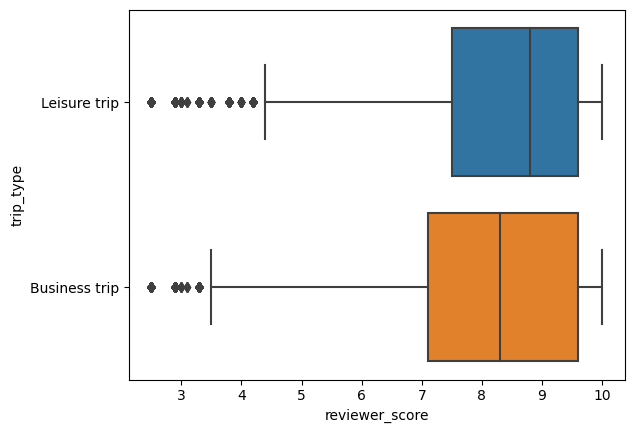

In [534]:
import seaborn as sns
sns.boxplot(data, x="reviewer_score", y="trip_type")

Переведем в булеанов тип данных

In [535]:
data['trip_type'] = data['trip_type'].apply(lambda x: True if x == 'Leisure trip' else False)

In [536]:
data['trip_type'].value_counts()

True     324957
False     61846
Name: trip_type, dtype: int64

### Разберем второй признак

Создадим второй признак по количеству участников поездки

In [537]:
def typeget2(tag):
   tags = tag.lstrip("['").rstrip("']").split("', '")
   company = ['Couple', 'Solo traveler', 'Family with young children', 'Group', 'Family with older children', 'Travelers with friends' ]
   if tags[0] in company:
    return str(tags[0]).strip()
   else:
     try:
      if str(tags[1]).strip() in company:
        return str(tags[1]).strip()
     except:
      return np.nan
    

data['company_type'] = data['tags'].apply(typeget2)
data['company_type'].isnull().mean() * 100

3.1313097364808447

In [538]:
data['company_type'].value_counts()

Couple                        184353
Solo traveler                  77880
Group                          47801
Family with young children     44026
Family with older children     19046
Travelers with friends          1585
Name: company_type, dtype: int64

Оценим признаки предварительно через ящики с усами, результаты согласуются со здравым смыслом: наиболее довольный посетители "парочки" и посетители с друзьями, так как они довольны помимо отеля и проведением времени вместе

наименее удовлетворены одинокие посетители, так как они бывают наиболее искушенными посетителями, находящимися помимо прочего в командировке (по которой как видно из предыдущих графиков отзывы меньше)

<Axes: xlabel='reviewer_score', ylabel='company_type'>

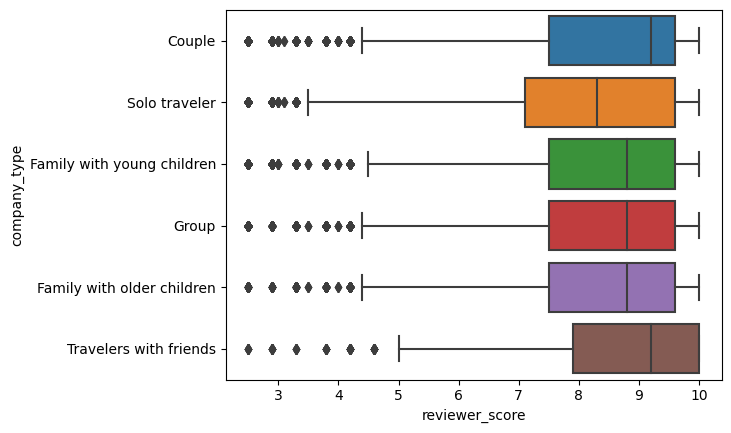

In [539]:
sns.boxplot(data, x="reviewer_score", y="company_type")

Проверим специализации отелей

In [540]:
auxilary_data = data.groupby(by= 'hotel_name', as_index=False)['company_type'].agg(pd.Series.mode)

In [541]:
def auxilary_from_array(mode_value):
  try:
    mode_value.shape
    return mode_value[0]
  except:
    return mode_value

In [542]:
auxilary_data

,hotel_name,company_type
0,11 Cadogan Gardens,Couple
1,1K Hotel,Couple
2,25hours Hotel beim MuseumsQuartier,Couple
3,41,Couple
4,45 Park Lane Dorchester Collection,Couple
...,...,...
1487,citizenM London Bankside,Couple
1488,citizenM London Shoreditch,Couple
1489,citizenM Tower of London,Couple
1490,every hotel Piccadilly,Couple


In [543]:
auxilary_data['company_type'] = auxilary_data['company_type'].apply(auxilary_from_array)

In [544]:
merged = data.merge(
    auxilary_data,
    on='hotel_name',
    how='left'
)
data = merged
data = data.fillna({'company_type_x' : data['company_type_y']})
data['company_type'] = data['company_type_x']

Удалим образовавшиеся ненужные столбцы

In [545]:
data = data.drop(['company_type_x', 'company_type_y'], axis=1)

### Разберем третий признак

In [546]:
def room_clarifier(room_type):

  room_type = room_type.lower()
  if 'double' in room_type or 'twin' in room_type or 'triple' in room_type:
    type1 = 'enlarged_room'
  else:
    type1 = 'simple_size'
  if 'superior' in room_type or 'deluxe' in room_type or 'comfort' in room_type or 'executive' in room_type:
    type2 = 'extracomfort'
  else:
    type2 = 'no_extra_comfort'
  return type1 + "_" + type2



In [547]:
def typeget3(tag):
   tags = tag.lstrip("['").rstrip("']").split("', '")
   company = ['Couple', 'Solo traveler', 'Family with young children', 'Group', 'Family with older children', 'Travelers with friends' ]
   try:
    if str(tags[1]).strip() not in company:
      typeroom = tags[1].strip()
    try:
      if 'Stayed' not in tags[2]:
        typeroom = tags[2].strip()
      else:
        return np.nan
    except:
      return np.nan
   except:
      return np.nan
   return room_clarifier(typeroom)
   
    
data['room_type'] = data['tags'].apply(typeget3)
data['room_type'].isnull().mean()

0.028963063885233568

Проведем предварительный анализ влияния типа комнаты на оценку

<Axes: xlabel='reviewer_score', ylabel='room_type'>

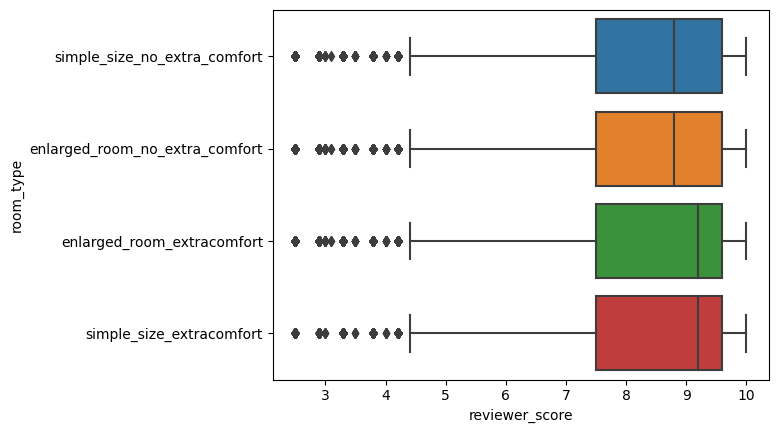

In [548]:
sns.boxplot(data, x="reviewer_score", y="room_type")

Пустые значения заполним модой

In [549]:
data = data.fillna({'room_type' : data['room_type'].mode()[0]})

### Разберем четвертый признак

In [550]:
def typeget4(tag):
   tags = tag.lstrip("['").rstrip("']").split("', '")
   try:
    if 'Stayed' in tags[2]:
      tag = tags[2]
    try:
      if 'Stayed' in tags[3]:
        tag = tags[3]
      try:
        if 'Stayed' in tags[4]:
          tag = tags[4]
      except:
        return np.nan
    except:
      return np.nan
   except:
    return np.nan
   else:
    stay_dur = int(tag.split()[1])
    if stay_dur >=7:
      return "More than a week"
    return str(stay_dur)
data['stay_duration'] = data['tags'].apply(typeget4)
data['stay_duration'].isnull().mean()

0.4208473047003255

In [551]:
data['stay_duration'].value_counts()

1                   85054
2                   58294
3                   41734
4                   20257
5                    8691
More than a week     5845
6                    4143
Name: stay_duration, dtype: int64

<Axes: xlabel='reviewer_score', ylabel='stay_duration'>

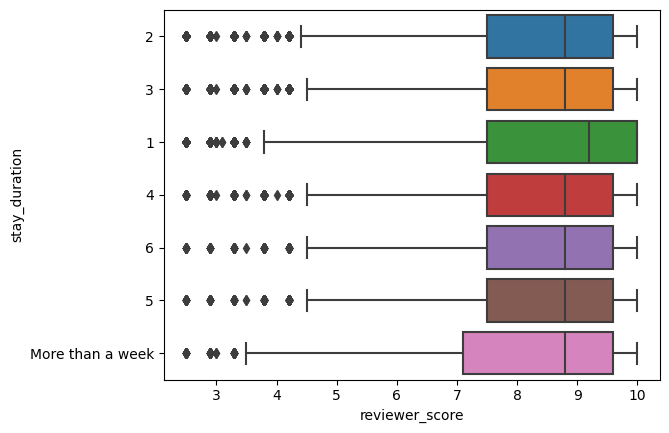

In [552]:
sns.boxplot(data, x="reviewer_score", y="stay_duration")

In [553]:
data = data.fillna({'stay_duration' : 'NoData'})

несмотря на выраженность числом будем относиться к признаку как категориальному, пропущенные значения (которыз много) примем за харктеристику признака

показатель бронирования через мобильное положение не представляется с точки зрения здравого смысла влияющим на оценку пользователя

### Удалим столбец тэгов 

In [554]:
data = data.drop(['tags'], axis=1)

## Добавим галочки для известных сетей отелей

In [555]:
list_of_famous_chains = ['Hilton', 'Renaissance', 'Marriott', 'Holiday Inn', 'Radisson', 'Mercure', 'Ritz']
def chain_checker(full_name):
  for chain in list_of_famous_chains:
    if chain in full_name:
      return True
  return False



data['chain'] = data['hotel_name'].apply(chain_checker)
   

пропусков в данных нет, ящик с усами показывает, что у сетивиков оценки ниже

получили бинарный признак

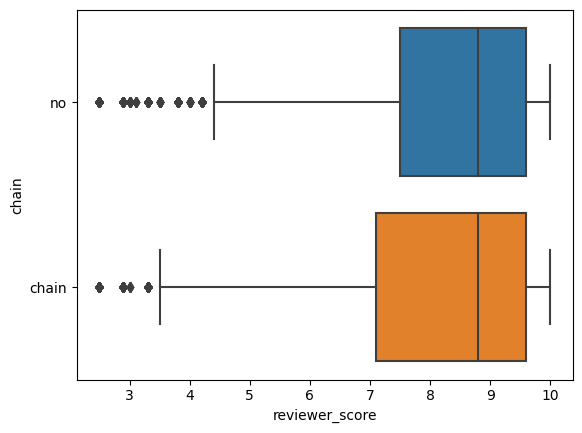

Само название отеля в дальнейшем закодируем

## Поработаем со строкой адреса, из нее можно узнать следующие данные:
- город отеля
- сопоставивить расстояние от отеля до центра города из информации в столбцах lat и lng
- страну
- сопоставить, является ли поездка для рецензента внутри страны или заграничной


In [556]:
def city_extracter(address):
  for x in ['Amsterdam', 'London', 'Paris', 'Barcelona', 'Vienna', 'Milan']:
    if x in address:
      return x
  
data['city'] = data['hotel_address'].apply(city_extracter)

In [557]:
data['city'].value_counts()

London       196774
Barcelona     45132
Paris         44658
Amsterdam     43178
Vienna        29178
Milan         27883
Name: city, dtype: int64

### Создадим признак: соответствует ли страна происхождения рецензента стране, где расположен отель

In [558]:
data['reviewer_nationality'].loc[5]

' France '

In [559]:
def country_extracter(address):
  for x in ['United Kingdom', 'Netherlands', 'France', 'Austria', 'Spain', 'Italy']:
    if x in address:
      return ' ' + x + ' '
data['country'] = data['hotel_address'].apply(country_extracter)

In [560]:
data['inner_trip'] = data['country'] == data['reviewer_nationality']

In [561]:
data = data.drop(['reviewer_nationality', 'country'], axis= 1)

### Узнаем расстояние от центра через отдельно созданную таблицу с координатами центров городов

In [562]:
coordinates = pd.DataFrame({
    'city': ['Amsterdam', 'London', 'Paris', 'Barcelona', 'Vienna', 'Milan'],
    'latitude': [	52.374,  	51.5085, 48.8534, 41.3888, 48.2085, 45.4643],
    'longitude': [4.88969, -0.12574,  2.3488, 2.15899, 16.3721, 9.18951]
})

строки в которых значения широты и долготы пропущены подлежат удалению

In [563]:
data = data.dropna(how='any', axis=0)

Объединим таблицы

In [564]:
merged = data.merge(
    coordinates,
    on='city',
    how='left'
)

По побочным знаниям географии определим расстояние отелей от центра в метрах на основании координат центра и

In [565]:
lat_dif = 111*((merged['lat'] - merged['latitude'])**2)
long_dif = 70*((merged['lng'] - merged['longitude'])**2)
merged['distance_meteres'] = (long_dif + lat_dif) ** 0.5 
data = merged

In [566]:
data['distance_meteres'].max()

42.637080583583554

Удалим ставшие ненужными признаки

In [567]:
data = data.drop(['lat', 'lng', 'latitude', 'longitude', 'hotel_address'], axis= 1)

## Разберем строки даты:
- выделим даты посещения отеля
- выделим сезон
- промежуток времени, через который был оставлен отзыв

In [568]:
data['review_date']

0          2/19/2016
1          1/12/2017
2         10/18/2016
3          9/22/2015
4           3/5/2016
             ...    
384350     4/19/2017
384351     2/13/2017
384352      2/7/2016
384353     5/21/2017
384354      8/5/2016
Name: review_date, Length: 384355, dtype: object

In [569]:
data['review_date'] = pd.to_datetime(data['review_date'])

In [570]:
data['season'] = data['review_date'].dt.month.apply(lambda x: 'summer' if x in [12,1,2] else 'spring' if x in [3,4,5] else 'autumn' if x in [6,7,8] else 'winter')

Не могу сделать логическую интерпретацию признака срока размещения рецензии, поэтому удалим этот признак 

In [571]:
data['days_since_review']

0         531 day
1         203 day
2         289 day
3         681 day
4         516 day
           ...   
384350    106 day
384351    171 day
384352    543 day
384353    74 days
384354    363 day
Name: days_since_review, Length: 384355, dtype: object

Удалим признаки даты и дней с момента размещения рецензии

In [572]:
data = data.drop(['days_since_review', 'review_date'], axis= 1)

## Из текстов рецензий выделим основные причины недовольства или удовлетворенности клиентов

### Персонал

In [573]:
func1 = lambda x: True if 'staff' in x.lower() or 'service' in x.lower() else False
data['positive_attitude'] = data['positive_review'].apply(func1)
data['negative_attitude'] = data['negative_review'].apply(func1)

### Состояние номеров


In [574]:
data['positive_comfort_level'] = data['positive_review'].apply(lambda x: True if 'room' in x.lower() or 'comfort' in x.lower() or 'comfy' in x.lower() or 'clean' in x.lower() else False)
data['negative_comfort_level'] = data['negative_review'].apply(lambda x: True if 'room' in x.lower() or 'air cond' in x.lower() or 'smell' in x.lower() or 'dirt' in x.lower()
or 'filthy' in x.lower() or 'airdond' in x.lower()  or 'stink' in x.lower() else False)

### Расположение

In [575]:
func1 = lambda x: True if 'locat' in x.lower() or 'walk' in x.lower() or 'metro' in x.lower() or 'underground' in x.lower() or 'view' in x.lower() or 'subway' in x.lower() else False
data['positive_location'] = data['positive_review'].apply(func1)
data['negative_location'] = data['negative_review'].apply(func1)

In [576]:
data = data.drop(['positive_review', 'negative_review'], axis= 1)

In [577]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384355 entries, 0 to 384354
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                384355 non-null  int64  
 1   average_score                               384355 non-null  float64
 2   hotel_name                                  384355 non-null  object 
 3   review_total_negative_word_counts           384355 non-null  int64  
 4   total_number_of_reviews                     384355 non-null  int64  
 5   review_total_positive_word_counts           384355 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  384355 non-null  int64  
 7   reviewer_score                              384355 non-null  float64
 8   trip_type                                   384355 non-null  bool   
 9   company_type                                384355 non-null  object 
 

# Проведем анализ корреляций и нормализацию признаков

<ipython-input-578-8b96879b4d02>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

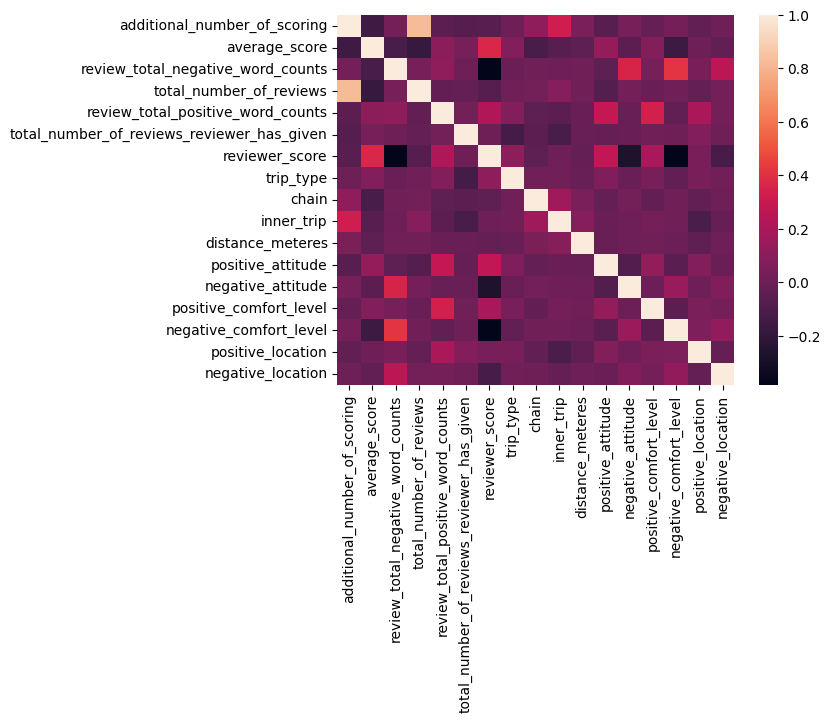

In [578]:
sns.heatmap(data.corr())

все полученные данные являются значимыми для ключевого признака и не имеют мультиколлинеарности

как было показано на боксплотах ранее - большинство отзывывов приближаются к 9-10, значит нужно провести нормализацию признака отзывы, использую е

проведем тест для определения нормальности данных

In [579]:
from scipy.stats import normaltest


In [580]:
_, p = normaltest(data['reviewer_score'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

_,p

(66176.13435526748, 0.0)

логарифмируем целевой признак

In [581]:
data['reviewer_score'] = np.log(data['reviewer_score'] + 1)

# Перейдем к кодировке категориальных признаков 

In [582]:
!pip install category_encoders
import category_encoders as ce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Применим однократное кодирование для времени года, города типа комнаты и типа поездки с другими людьми

In [583]:
data = pd.get_dummies(data, columns= ['season', 'city', 'room_type', 'company_type'])

## Применим порядковое кодирование для времени пребывания

In [584]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(data['stay_duration'])
data = data.drop(['stay_duration'], axis= 1)
data = pd.concat([data, data_bin], axis=1)

## Используем двоичное кодирование для кодировки отеля

In [585]:
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)



In [586]:
data = data.drop(['hotel_name'], axis= 1)

In [587]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384355 entries, 0 to 384354
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                384355 non-null  int64  
 1   average_score                               384355 non-null  float64
 2   review_total_negative_word_counts           384355 non-null  int64  
 3   total_number_of_reviews                     384355 non-null  int64  
 4   review_total_positive_word_counts           384355 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  384355 non-null  int64  
 6   reviewer_score                              384355 non-null  float64
 7   trip_type                                   384355 non-null  bool   
 8   chain                                       384355 non-null  bool   
 9   inner_trip                                  384355 non-null  bool   
 

# Обучим модель

In [588]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.05303961391770697
